In [81]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib as plt
import seaborn as sns
from statistics import mean
import sklearn
from sklearn import pipeline
from sklearn import set_config, metrics
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.svm import SVC
from sklearn.utils import compute_class_weight
from imblearn.pipeline import make_pipeline
from functools import lru_cache
from google.colab import drive
import json

In [82]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [83]:
set_config(display="diagram")
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("ticks")

In [84]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [96]:
def preprocess_text(text, lemmatize):
    try:
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower().split()
        text = [lemmatize(word) for word in text if not word in stopwords and len(word) > 1]
        return ' '.join(text)
    except TypeError:
        return ''

def preprocess_series(series):
    lemmatize = lru_cache(maxsize=50000)(nltk.stem.WordNetLemmatizer().lemmatize)
    return pd.Series([preprocess_text(text, lemmatize) for text in series])

def split_and_train_model(X, Y, pipe):
    x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=1)

    pipe.fit(x_train, y_train);

    predictions = pipe.predict(x_test)

    return y_test, predictions

def load_dataset(show_name):
    dframe = pd.read_csv(f"/content/drive/MyDrive/star_trek_data/{show_name}.csv", index_col=None, engine="python")
    classes = list(dframe["Character"].value_counts().index)
    X = pd.DataFrame(preprocess_series(dframe["Lines"]),columns = ["Lines"])
    Y = dframe["Character"]
    return X, Y

def get_pipeline(classifier):
    return make_pipeline(
        make_column_transformer(
            (TfidfVectorizer(ngram_range=(1,3)), "Lines")
        ),
        classifier
    ) 

def get_cross_val_score(X, Y, pipe, cv=5, scoring="f1_macro"):
    return cross_val_score(
        pipe,
        X,
        Y,
        cv=cv, 
        scoring=scoring
    ).mean()

def get_classification_report(y_test, predictions, labels):
    return classification_report(
        y_test,
        predictions,
        labels=labels,
        output_dict=False
    )

def plot_confusion_matrix(y_true, predictions, labels):
    return metrics.ConfusionMatrixDisplay.from_predictions(
        y_true,
        predictions,
        cmap="Blues",
        xticks_rotation="vertical",
        labels=labels
    )

def get_class_weights(labels):
    target_names = labels.value_counts().index.to_list()
    class_weights = compute_class_weight(class_weight='balanced', classes=target_names, y=labels)
    indexes = list(range(len(target_names)))
    return dict(zip(target_names, class_weights))

In [87]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The Original Series**

              precision    recall  f1-score   support

        KIRK       0.73      0.55      0.62      2364
       SPOCK       0.46      0.72      0.56      1094
       MCCOY       0.42      0.44      0.43       614
       SCOTT       0.49      0.30      0.37       324
        SULU       0.35      0.27      0.30       163
       UHURA       0.41      0.29      0.34       146
      CHEKOV       0.06      0.06      0.06        79
        PIKE       0.59      0.53      0.56        55
        MUDD       0.03      0.12      0.05        33
      CHAPEL       0.08      0.27      0.12        26

    accuracy                           0.53      4898
   macro avg       0.36      0.35      0.34      4898
weighted avg       0.57      0.53      0.53      4898



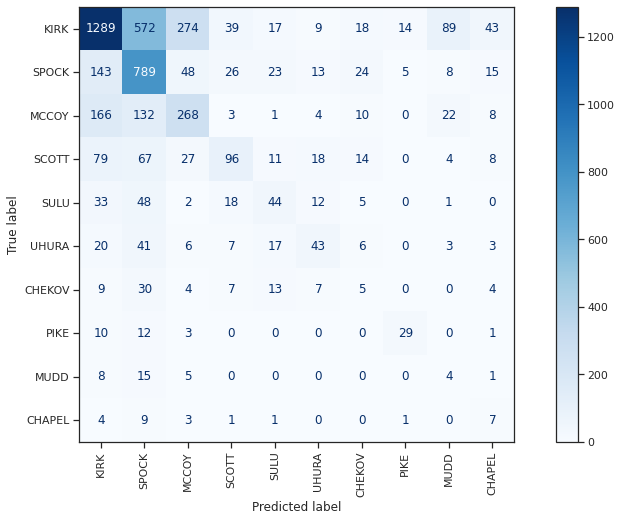

In [99]:
X, Y = load_dataset("TOS")
labels = Y.value_counts().index.to_list()
class_weights = get_class_weights(Y)
model = SVC(class_weight = class_weights)
y_test, predictions = split_and_train_model(X, Y, get_pipeline(model))
print(get_classification_report(y_test, predictions, labels))
plot_confusion_matrix(y_test, predictions, labels)

**The Next Generation**

              precision    recall  f1-score   support

      PICARD       0.59      0.44      0.50      3136
       RIKER       0.33      0.33      0.33      1793
        DATA       0.42      0.59      0.49      1530
     LAFORGE       0.37      0.42      0.40      1080
        WORF       0.39      0.26      0.31       886
     CRUSHER       0.26      0.25      0.26       723
        TROI       0.23      0.33      0.27       749
      WESLEY       0.15      0.14      0.14       299
           Q       0.03      0.01      0.02       147
       TASHA       0.03      0.05      0.04       115

    accuracy                           0.39     10458
   macro avg       0.28      0.28      0.28     10458
weighted avg       0.41      0.39      0.39     10458



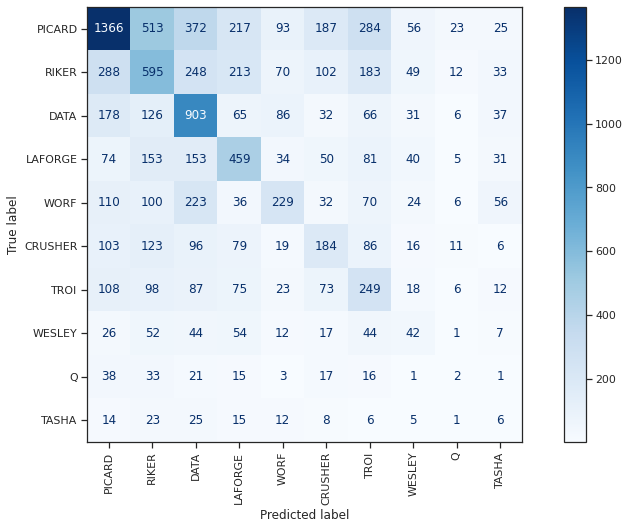

In [100]:
X, Y = load_dataset("TNG")
labels = Y.value_counts().index.to_list()
class_weights = get_class_weights(Y)
model = SVC(class_weight = class_weights)
y_test, predictions = split_and_train_model(X, Y, get_pipeline(model))
print(get_classification_report(y_test, predictions, labels))
plot_confusion_matrix(y_test, predictions, labels)

**Deep Space Nine**

              precision    recall  f1-score   support

       SISKO       0.40      0.37      0.39      2148
        KIRA       0.24      0.23      0.23      1287
      BASHIR       0.29      0.28      0.28      1241
     O'BRIEN       0.32      0.27      0.29      1213
         ODO       0.23      0.24      0.24      1115
       QUARK       0.33      0.38      0.35      1017
         DAX       0.29      0.27      0.28       909
        WORF       0.27      0.21      0.23       495
       GARAK       0.14      0.10      0.12       366
        JAKE       0.11      0.27      0.16       350

    accuracy                           0.29     10141
   macro avg       0.26      0.26      0.26     10141
weighted avg       0.30      0.29      0.29     10141



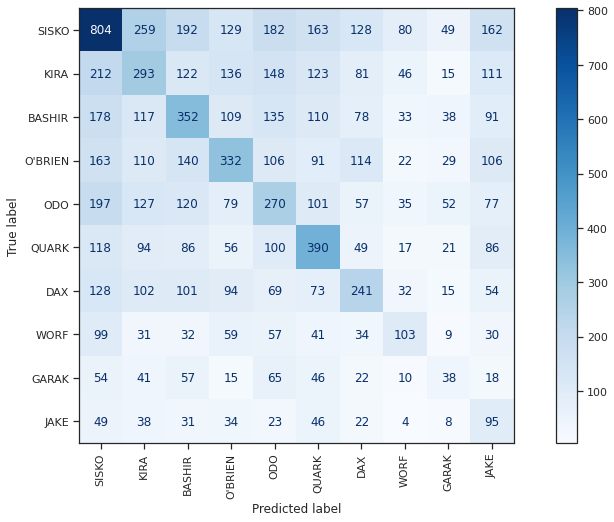

In [101]:
X, Y = load_dataset("DS9")
labels = Y.value_counts().index.to_list()
class_weights = get_class_weights(Y)
model = SVC(class_weight = class_weights)
y_test, predictions = split_and_train_model(X, Y, get_pipeline(model))
print(get_classification_report(y_test, predictions, labels))
plot_confusion_matrix(y_test, predictions, labels)

**Voyager**

              precision    recall  f1-score   support

     JANEWAY       0.49      0.34      0.40      2983
    CHAKOTAY       0.21      0.25      0.23      1394
         EMH       0.32      0.42      0.36      1349
       PARIS       0.27      0.28      0.27      1183
       TUVOK       0.35      0.42      0.38      1089
         KIM       0.25      0.22      0.24      1039
      TORRES       0.21      0.18      0.19      1062
       SEVEN       0.40      0.39      0.40      1011
      NEELIX       0.21      0.17      0.19       780
         KES       0.06      0.16      0.09       292

    accuracy                           0.30     12182
   macro avg       0.28      0.28      0.27     12182
weighted avg       0.32      0.30      0.31     12182



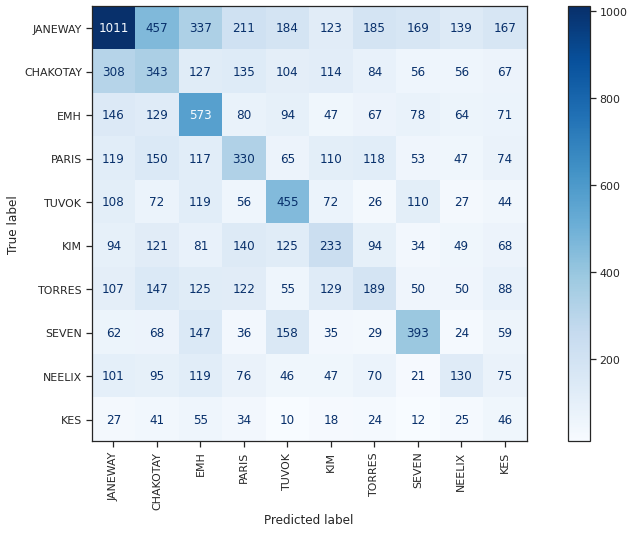

In [102]:
X, Y = load_dataset("VOY")
labels = Y.value_counts().index.to_list()
class_weights = get_class_weights(Y)
model = SVC(class_weight = class_weights)
y_test, predictions = split_and_train_model(X, Y, get_pipeline(model))
print(get_classification_report(y_test, predictions, labels))
plot_confusion_matrix(y_test, predictions, labels)

**Enterprise**

              precision    recall  f1-score   support

      ARCHER       0.60      0.29      0.39      2182
      TUCKER       0.32      0.49      0.39      1102
       T'POL       0.34      0.59      0.43      1076
        REED       0.31      0.23      0.26       626
       PHLOX       0.32      0.31      0.32       449
       HOSHI       0.20      0.13      0.16       316
      TRAVIS       0.26      0.18      0.21       302
       SHRAN       0.07      0.19      0.10        95
       DEGRA       0.10      0.11      0.11        70
       SOVAL       0.00      0.00      0.00        46

    accuracy                           0.35      6264
   macro avg       0.25      0.25      0.24      6264
weighted avg       0.40      0.35      0.35      6264



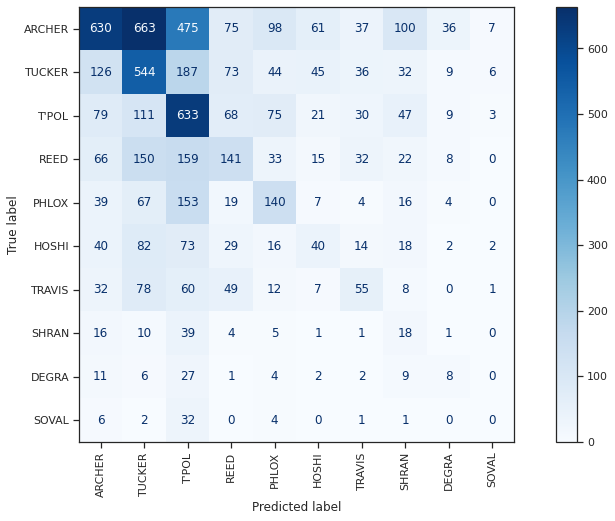

In [103]:
X, Y = load_dataset("ENT")
labels = Y.value_counts().index.to_list()
class_weights = get_class_weights(Y)
model = SVC(class_weight = class_weights)
y_test, predictions = split_and_train_model(X, Y, get_pipeline(model))
print(get_classification_report(y_test, predictions, labels))
plot_confusion_matrix(y_test, predictions, labels)

**The Animated Series**

              precision    recall  f1-score   support

        KIRK       0.65      0.78      0.71       330
       SPOCK       0.53      0.79      0.63       196
       MCCOY       0.64      0.24      0.35        96
       SCOTT       0.71      0.20      0.32        49
        SULU       0.41      0.20      0.27        44
       UHURA       0.03      0.02      0.02        52
      CHAPEL       0.00      0.00      0.00        12
        MUDD       0.00      0.00      0.00         6
    COMPUTER       0.67      0.20      0.31        10
     Y SPOCK       0.00      0.00      0.00         5

    accuracy                           0.57       800
   macro avg       0.36      0.24      0.26       800
weighted avg       0.55      0.57      0.53       800



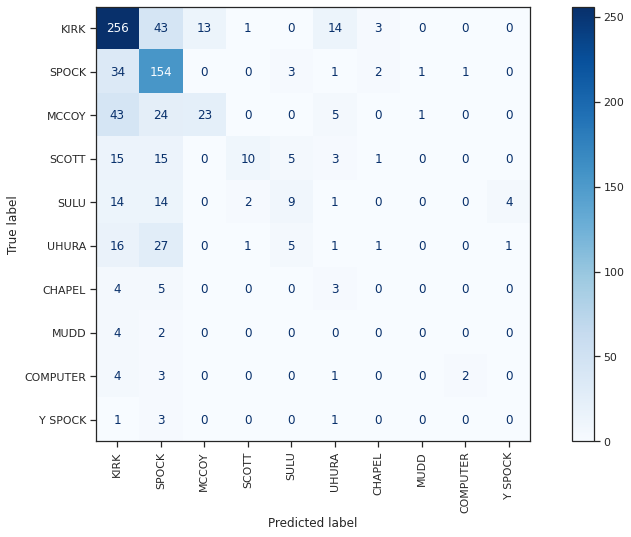

In [104]:
X, Y = load_dataset("TAS")
labels = Y.value_counts().index.to_list()
class_weights = get_class_weights(Y)
model = SVC(class_weight = class_weights)
y_test, predictions = split_and_train_model(X, Y, get_pipeline(model))
print(get_classification_report(y_test, predictions, labels))
plot_confusion_matrix(y_test, predictions, labels)